# Regress age from syllables/tm

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from aging.behavior.syllables import relabel_by_usage, assign_onsets
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.metrics import r2_score
from toolz import frequencies, sliding_window
from aging.plotting import format_plots, PlotConfig, save_factory, figure
from scipy import stats

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "age-regression", tight_layout=False)

In [3]:
def compute_tm(df, flat=True):
    rle = df.query('onsets')['relabeled_syllables']
    counts = frequencies(sliding_window(2, rle))
    tm = np.zeros((rle.max() + 1,) * 2)
    for k, v in counts.items():
        tm[k] = v
    if flat:
        s = pd.Series(tm[~np.eye(tm.shape[0], dtype=bool)].flatten() / np.sum(tm)).rename('freq')
        s.index.name = 'bigram'
        return s
    return tm / np.sum(tm)


def age_map(string) -> int:
    '''returns age in weeks'''
    if '3m' in string:
        return 3 * 4
    if '6m' in string:
        return 6 * 4
    if '9m' in string:
        return 9 * 4
    if '12m' in string:
        return 12 * 4
    if '18m' in string:
        return 18 * 4
    if '22m' in string:
        return 22 * 4
    if '3w' in string:
        return 3
    if '5w' in string:
        return 5
    if '7w' in string:
        return 7
    if '9w' in string:
        return 9
    if '90w' in string:
        return 90

In [4]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_03/ontogeny_males_syllable_df.parquet')
df, usage_map = relabel_by_usage(df)
df['age'] = df['age'].map(age_map)

In [5]:
usage_df = df.query('onsets').groupby(['age', 'subject_name', 'uuid'])['relabeled_syllables'].value_counts(normalize=True)
usage_df.name = 'usage'
usage_df = usage_df.reset_index()

In [176]:
usage_mtx = usage_df.pivot_table(values='usage', columns='relabeled_syllables', index=['age', 'uuid']).fillna(0)

In [177]:
# usage_mtx = usage_mtx.drop(index=88, level=0)

In [8]:
# tms = df.query('onsets').groupby(['age', 'uuid'], sort=False).apply(compute_tm).reset_index()
# tm_mtx = tms.pivot_table(values='freq', columns='bigram', index=['age', 'uuid']).fillna(0)

## Leave subset out of each group

In [178]:
param_grid = dict(plsregression__n_components=range(1, 15))
grid = ParameterGrid(param_grid)

pipeline = make_pipeline(
    PLSRegression(n_components=1),
)

y = (usage_mtx.index.get_level_values(0))
lbls = LabelEncoder().fit_transform(y)

output = []

for param in tqdm(grid):
    mdl = pipeline.set_params(**param)
    preds = np.zeros_like(y)
    folds = StratifiedKFold(n_splits=6)
    for train, test in folds.split(usage_mtx, lbls):
        pipeline = pipeline.fit(np.log(usage_mtx.iloc[train] + 1e-6), y[train])
        preds[test] = pipeline.predict(np.log(usage_mtx.iloc[test] + 1e-6)).squeeze()
    output.append(dict(params=param, score=r2_score(y, preds)))

out = pd.DataFrame(output)
out = out.sort_values(by='score', ascending=False)
out.head()

  0%|          | 0/14 [00:00<?, ?it/s]

,params,score
3,{'plsregression__n_components': 4},0.797641
5,{'plsregression__n_components': 6},0.793286
4,{'plsregression__n_components': 5},0.789611
6,{'plsregression__n_components': 7},0.780670
7,{'plsregression__n_components': 8},0.772410


In [179]:
np.unique(y)

array([ 3,  5,  7,  9, 12, 24, 36, 48, 72, 88])

In [180]:
# ex = y[y == 72]
# ex_usage = usage_mtx[usage_mtx.index.get_level_values(0) == 72]
# usage_mtx = usage_mtx[usage_mtx.index.get_level_values(0) != 72]

In [181]:
pipeline = pipeline.set_params(**out.iloc[0]['params'])

y = (usage_mtx.index.get_level_values(0))
lbls = LabelEncoder().fit_transform(y)

preds = np.zeros_like(y)
folds = StratifiedKFold(n_splits=6)
for train, test in folds.split(usage_mtx, lbls):
    pipeline = pipeline.fit(np.log(usage_mtx.iloc[train] + 1e-6), y[train])
    preds[test] = pipeline.predict(np.log(usage_mtx.iloc[test] + 1e-6)).squeeze()
plt_out = dict(pls=(y, preds))

In [182]:
# pipeline.predict(np.log(ex_usage + 1e-6)).mean()

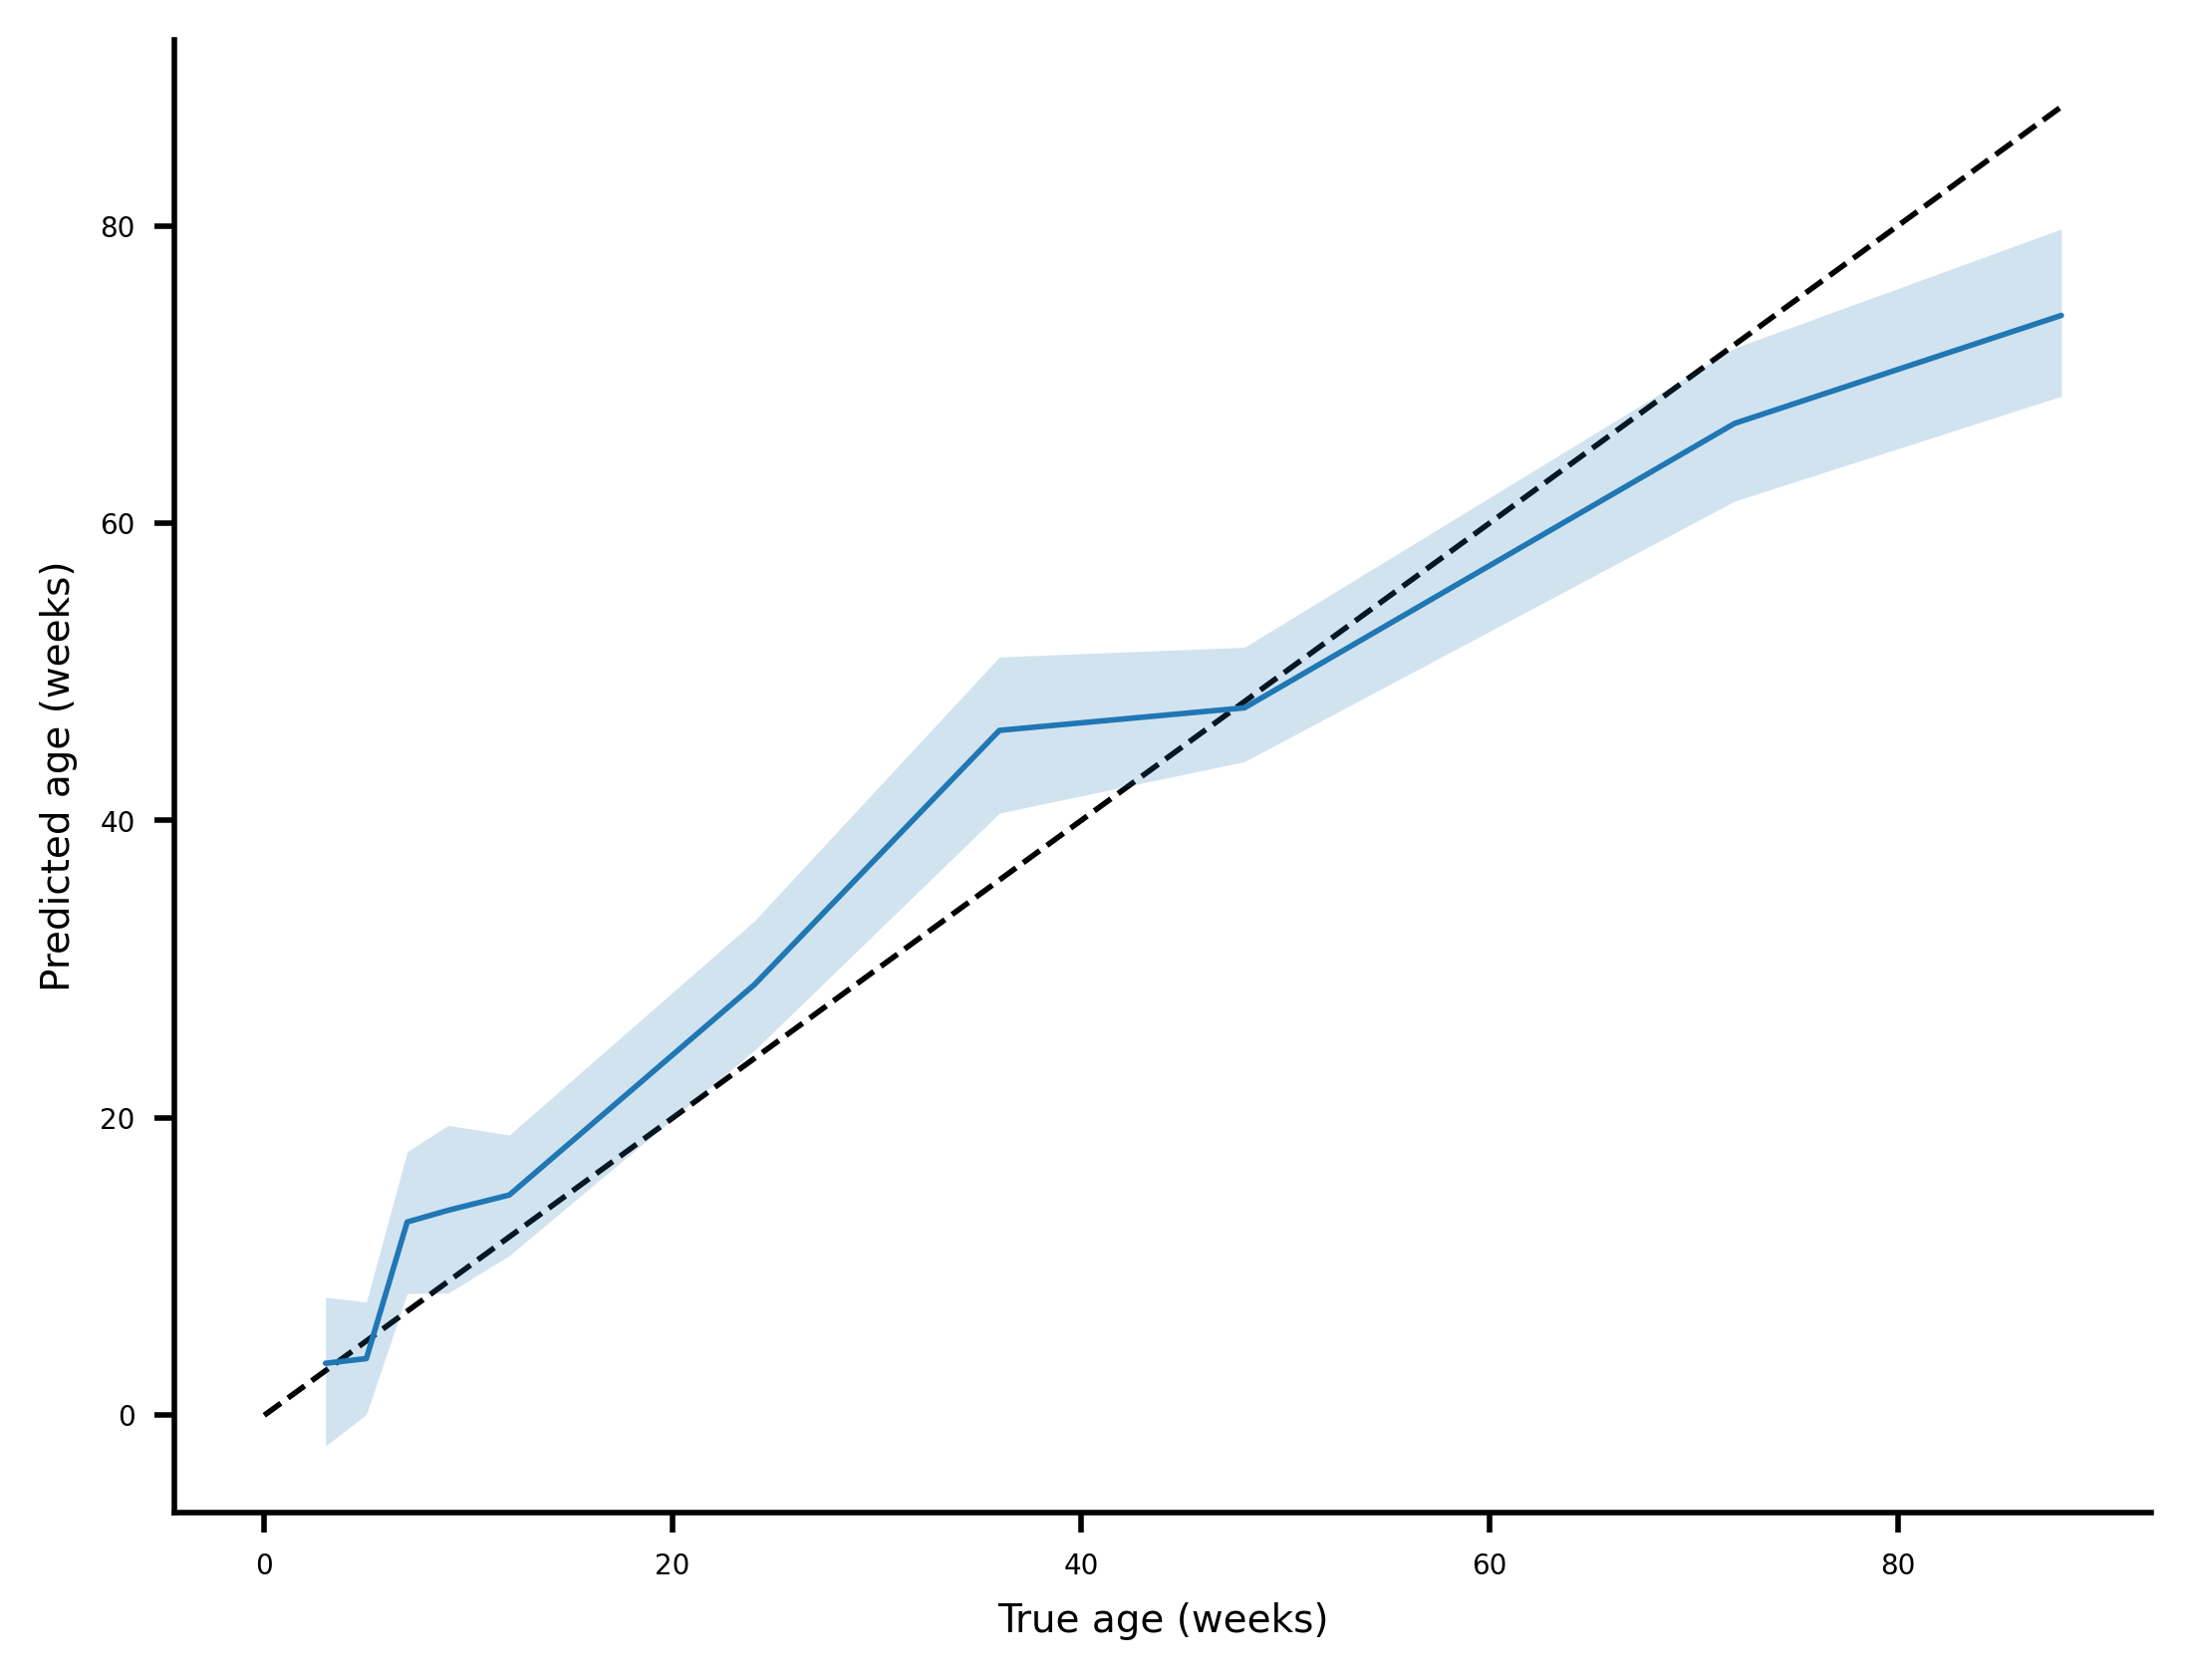

In [183]:
ax = sns.lineplot(y=(preds), x=(y), err_kws=dict(lw=0), zorder=5)
# plt.plot(72, pipeline.predict(np.log(ex_usage + 1e-6)).mean(), 'o')
ax.plot([0, 88], [0, 88], color='k', ls='--', zorder=-5)
ax.set(xlabel='True age (weeks)', ylabel='Predicted age (weeks)')
sns.despine()

## Load wheel data

In [15]:
wheel_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_03/wheel_syllable_df_v02.parquet')

In [16]:
wheel_df['uuid'].nunique()

497

In [17]:
mouse_id = wheel_df['subject_name'].str[:-3]
wheel_df['mouse_id'] = mouse_id

In [18]:
wheel_df = wheel_df[~wheel_df['subject_name'].str.startswith('M')]

In [19]:
min_date = pd.to_datetime('2023-06-01')

In [20]:
min_date

Timestamp('2023-06-01 00:00:00')

In [21]:
c = re.compile(r'^(\d{2})([wc])')


def get_experiment_and_age(row):
    grps = c.match(row['subject_name']).groups()
    starting_age = int(grps[0])
    exp = grps[1]
    current_age = starting_age + (row['date'] - min_date).days / 7
    row['age'] = current_age
    row['experiment'] = exp
    return row

In [22]:
names = wheel_df['subject_name'].unique()

In [23]:
wheel_df = assign_onsets(wheel_df)
wheel_df['relabeled_syllables'] = wheel_df['syllables'].map(usage_map)

In [193]:
# subset = wheel_df[wheel_df['date'] > pd.to_datetime('2023-06-15')].copy()
subset = wheel_df.copy()

In [194]:
search_str = re.compile(r'[wc](\d)')

In [195]:
subset['cage'] = subset['subject_name'].apply(lambda s: search_str.search(s).group(1))

In [196]:
wheel_usages = subset.query('onsets').groupby(['subject_name', 'mouse_id', 'date', 'cage'])['relabeled_syllables'].value_counts(normalize=True)
wheel_usages.name = 'usage'
wheel_usages = wheel_usages.reset_index().apply(get_experiment_and_age, axis=1)
wheel_mtx = wheel_usages.pivot_table(values='usage', columns='relabeled_syllables', index=['age', 'date', 'experiment', 'mouse_id', 'cage']).fillna(0)
wheel_mtx = wheel_mtx.reindex(columns=usage_mtx.columns).fillna(0)

In [197]:
pred_ages = pipeline.predict(np.log(wheel_mtx + 1e-6)).squeeze()

In [203]:
pred_df = pd.DataFrame(
    dict(
        age=wheel_mtx.index.get_level_values("age"),
        pred_age=pred_ages,
        experiment=wheel_mtx.index.get_level_values("experiment"),
        cage=wheel_mtx.index.get_level_values("cage"),
        date=wheel_mtx.index.get_level_values("date"),
    )
)

In [206]:
t_h = pred_df['date'].dt.hour
t_m = pred_df['date'].dt.minute

In [209]:
total_min = t_h * 60 + t_m

In [211]:
pred_df['t'] = total_min

In [212]:
pred_df['ec'] = pred_df['experiment'] + pred_df['cage']

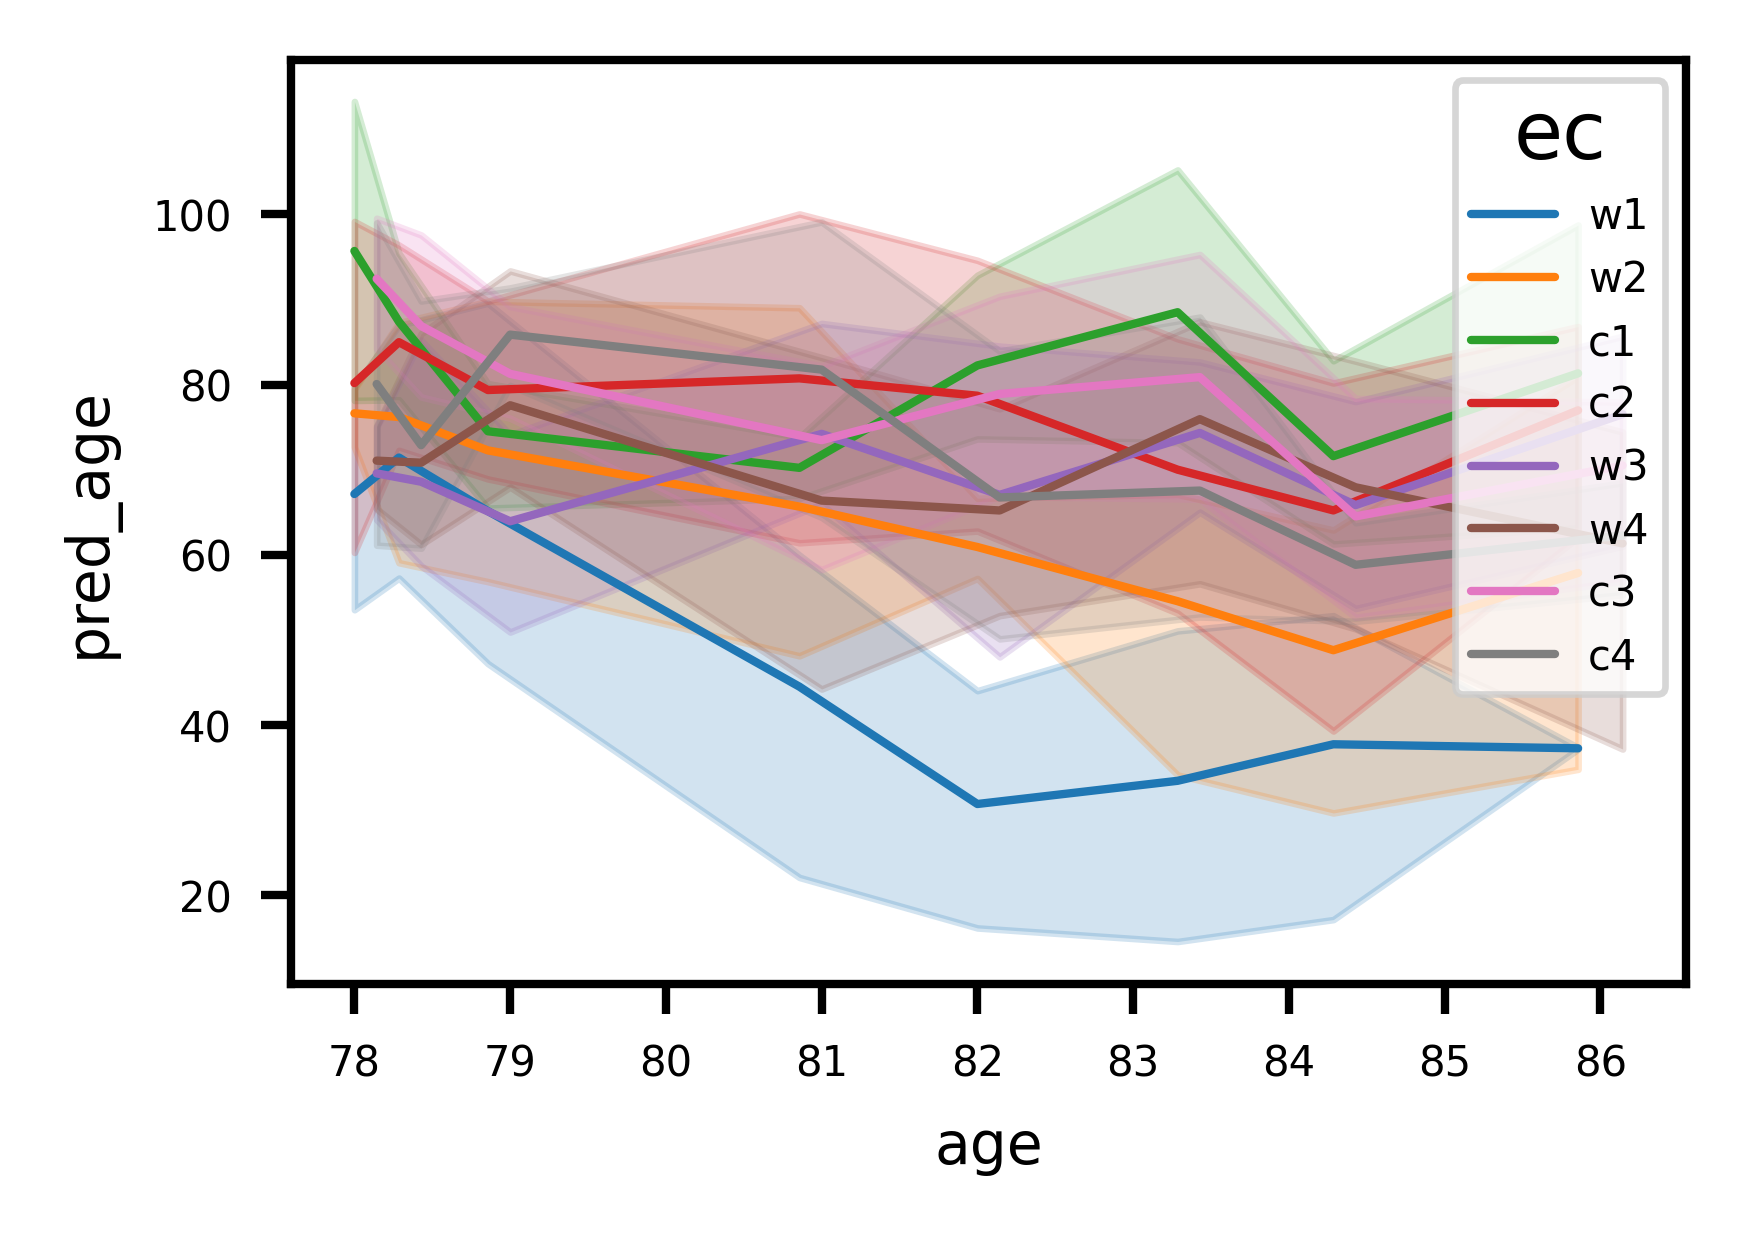

In [215]:
figure(3, 2)
ax = sns.lineplot(data=pred_df.query('age > 40'), x='age', y='pred_age', hue='ec')
# plt.plot([0, 90], [0, 90], ls='--', c='k')

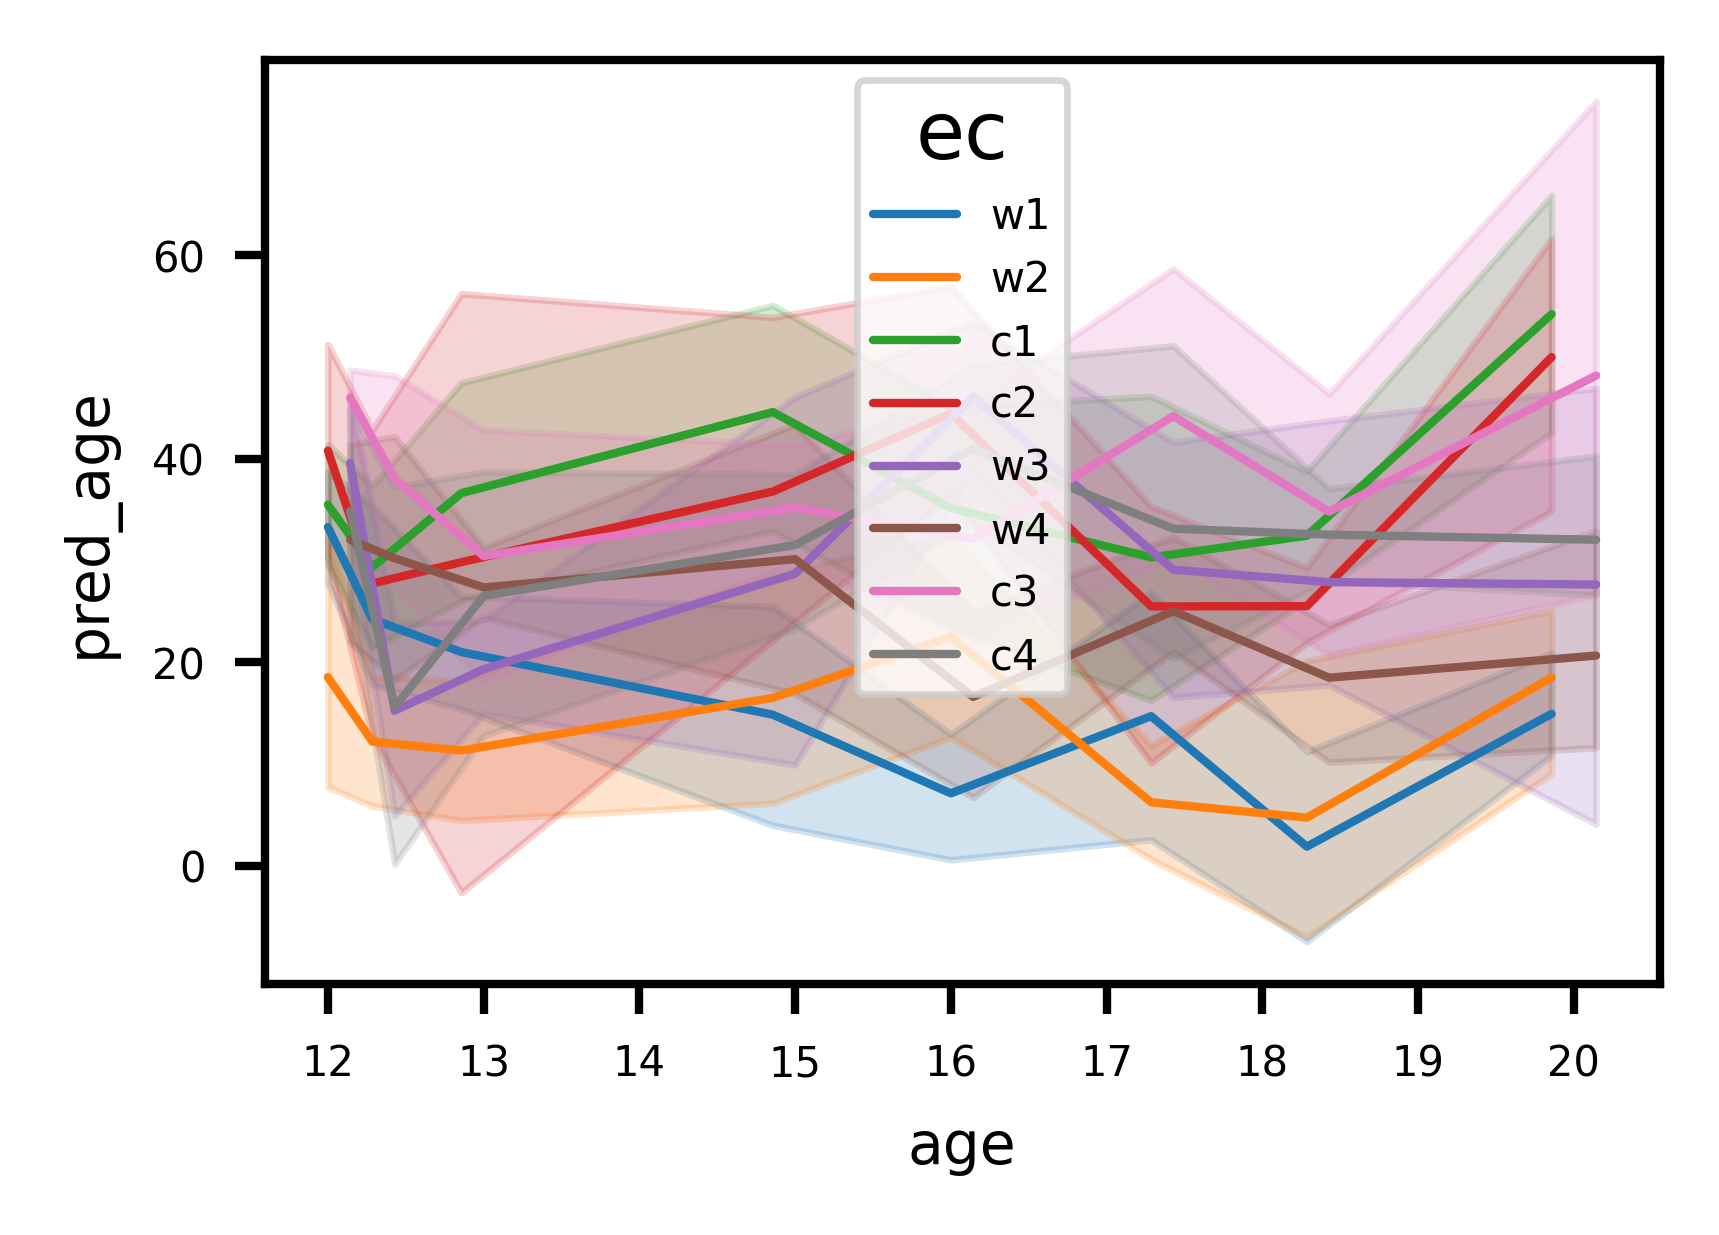

In [216]:
figure(3, 2)
ax = sns.lineplot(data=pred_df.query('age < 40'), x='age', y='pred_age', hue='ec')
# plt.plot([0, 90], [0, 90], ls='--', c='k')

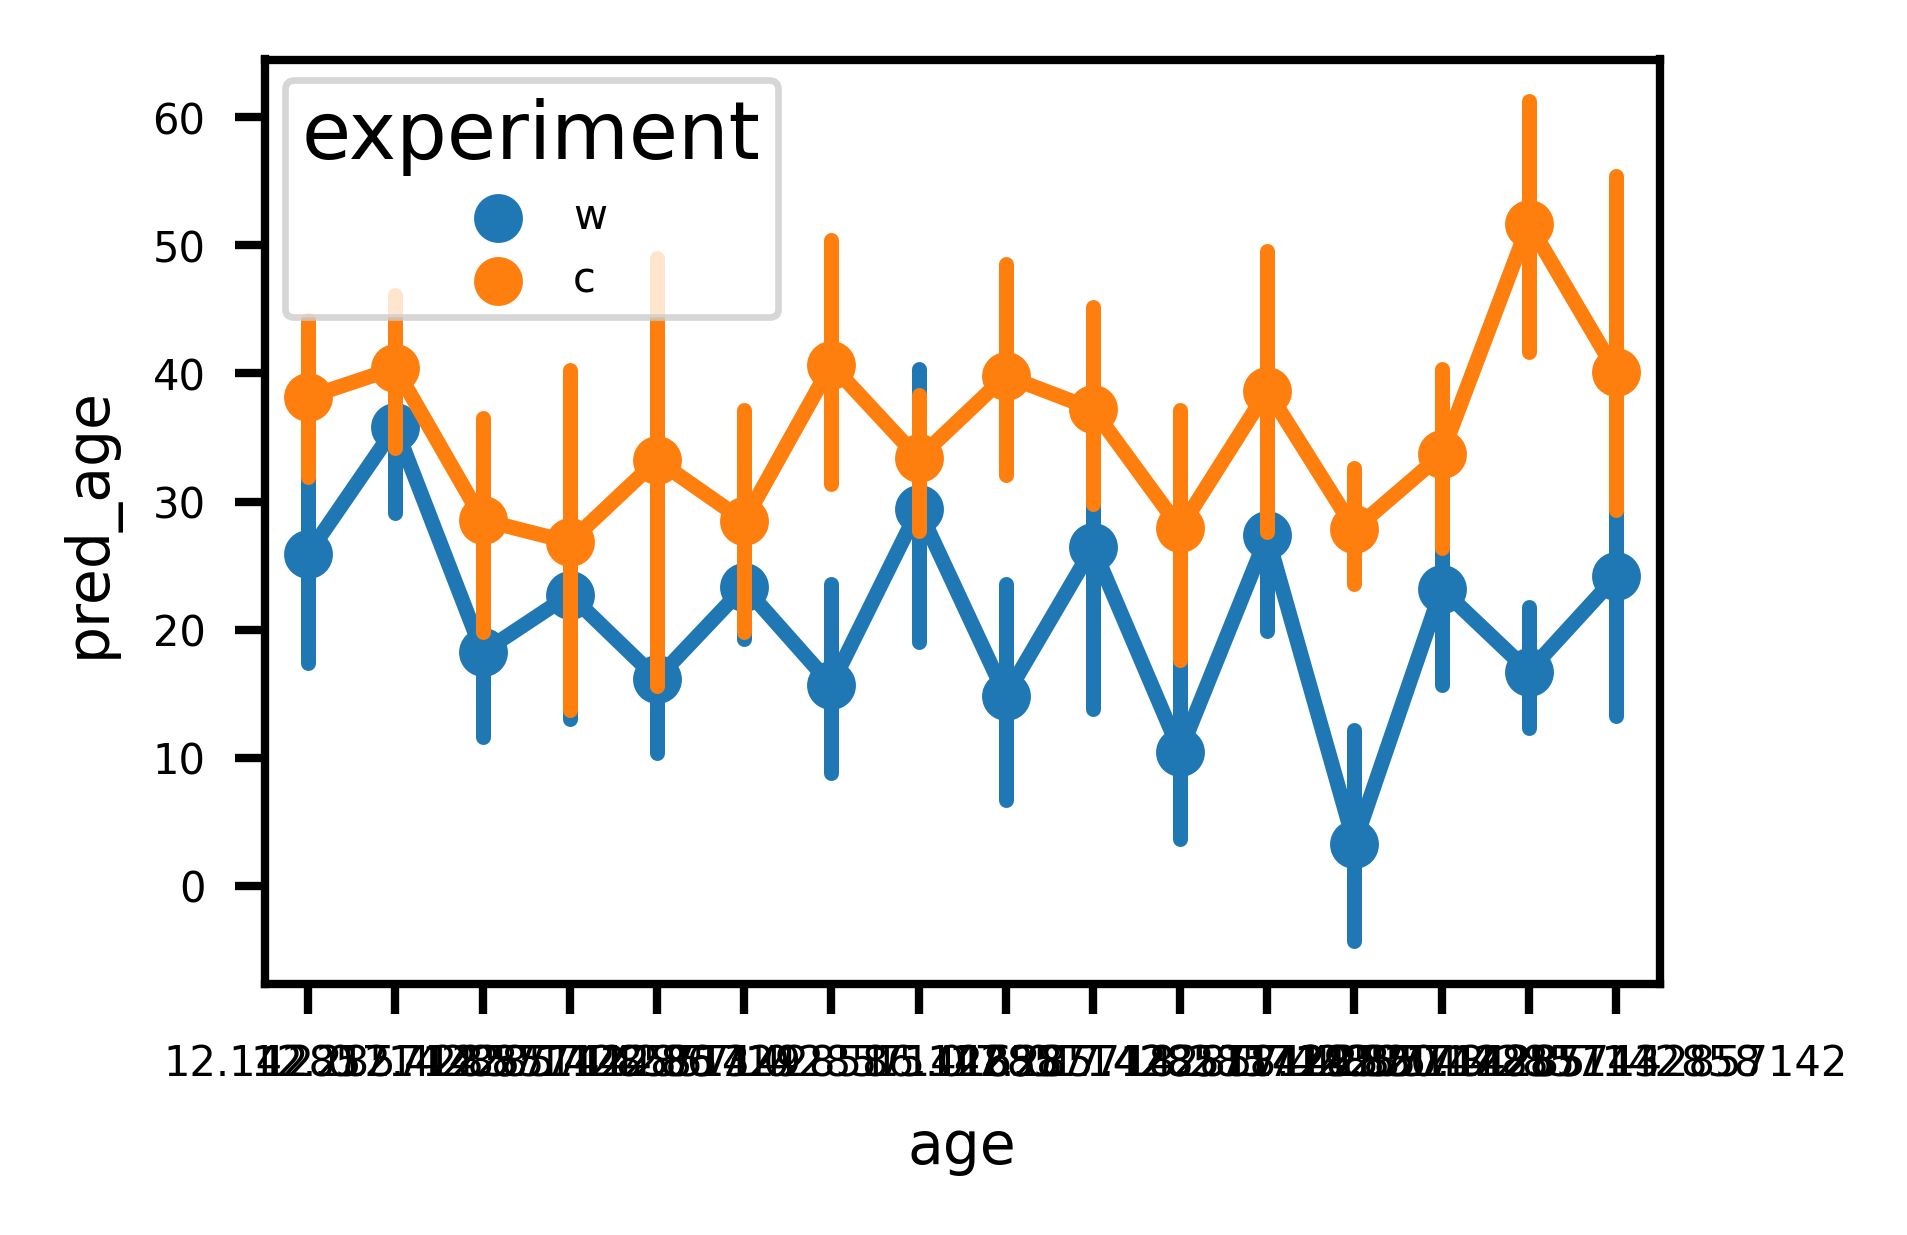

In [200]:
figure(3, 2)
ax = sns.pointplot(data=pred_df.query('age < 40'), x='age', y='pred_age', hue='experiment')
# plt.plot([0, 90], [0, 90], ls='--', c='k')

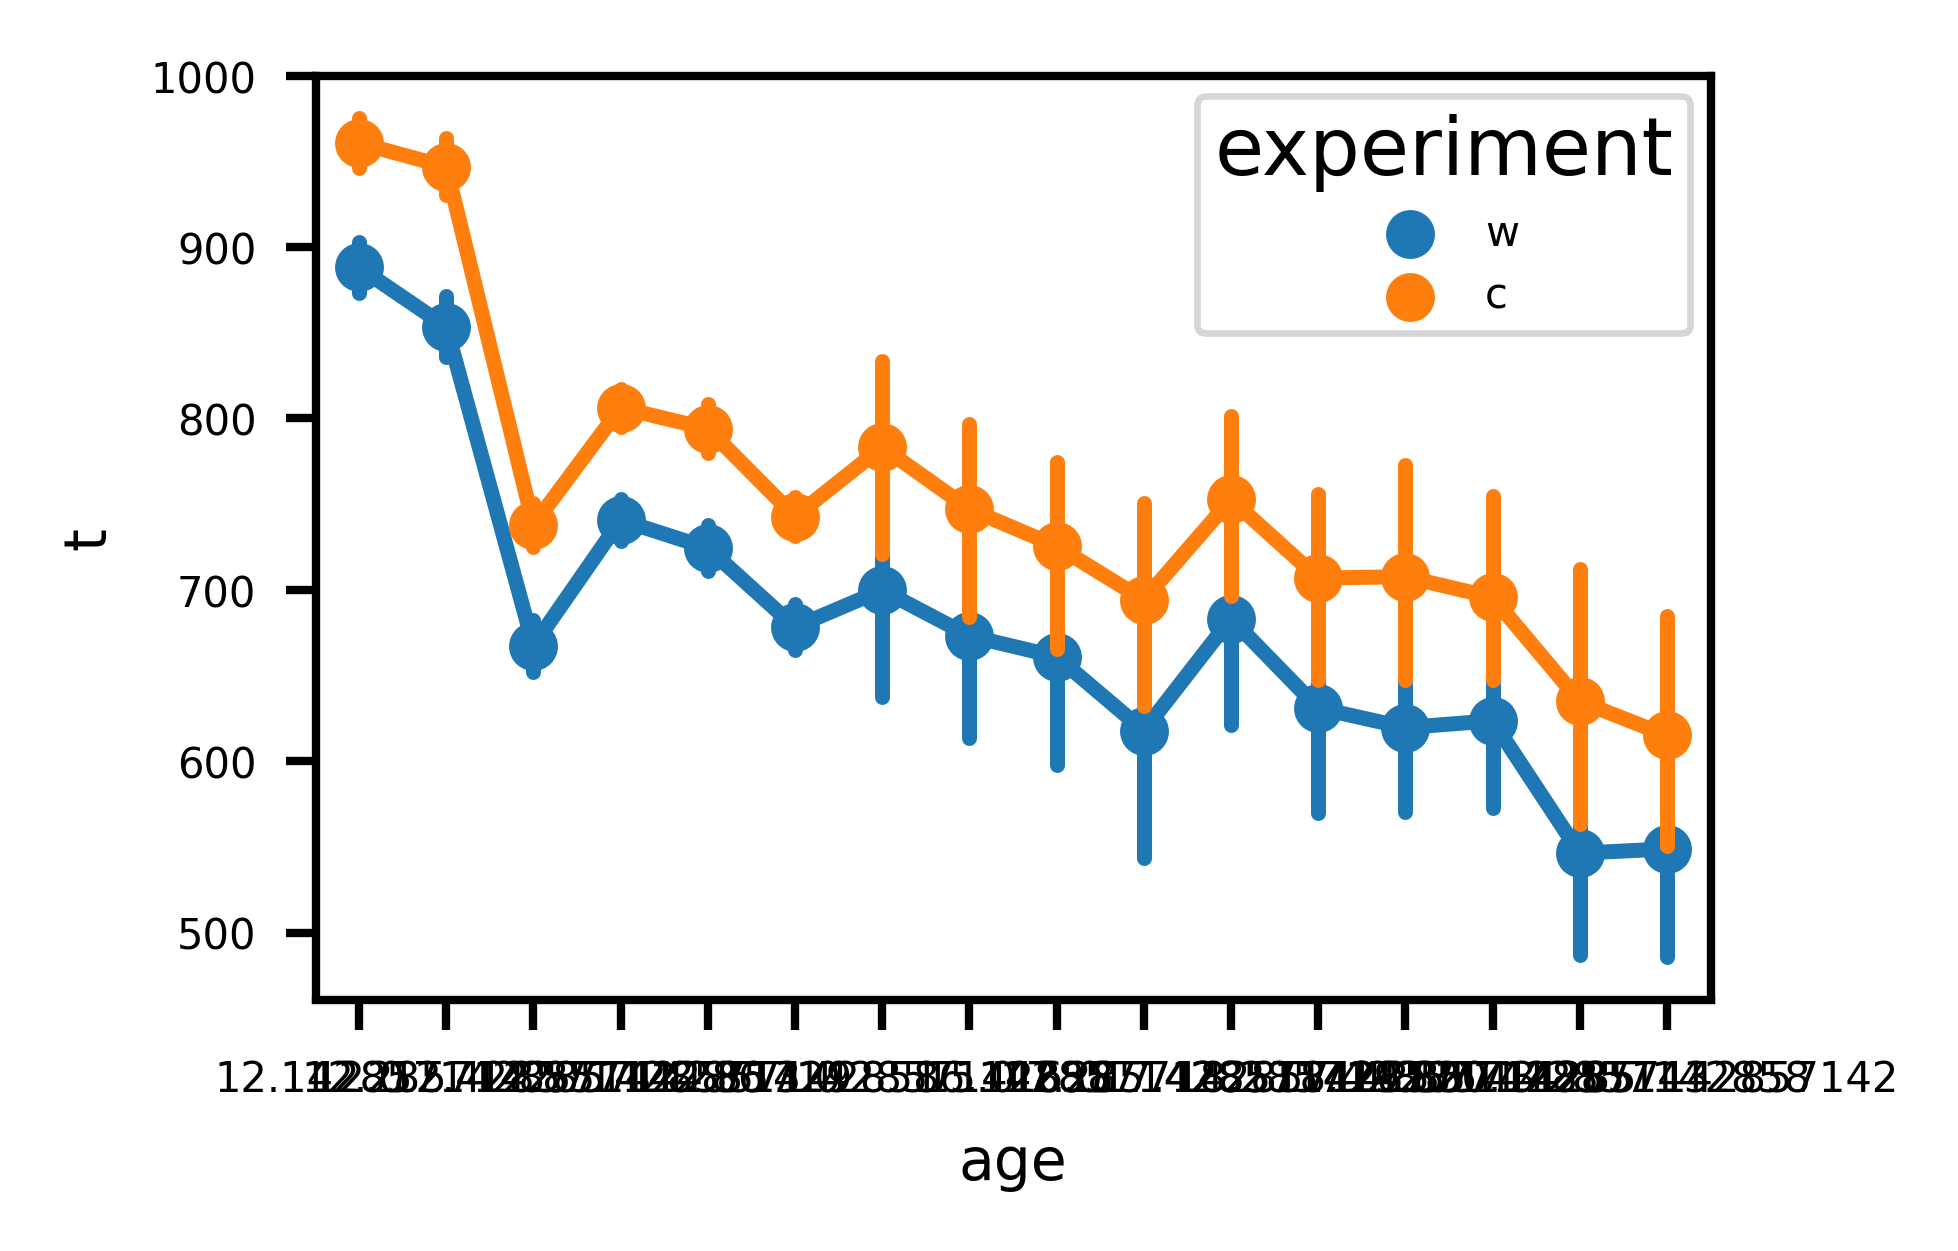

In [213]:
figure(3, 2)
ax = sns.pointplot(data=pred_df.query('age < 40'), x='age', y='t', hue='experiment')
# plt.plot([0, 90], [0, 90], ls='--', c='k')

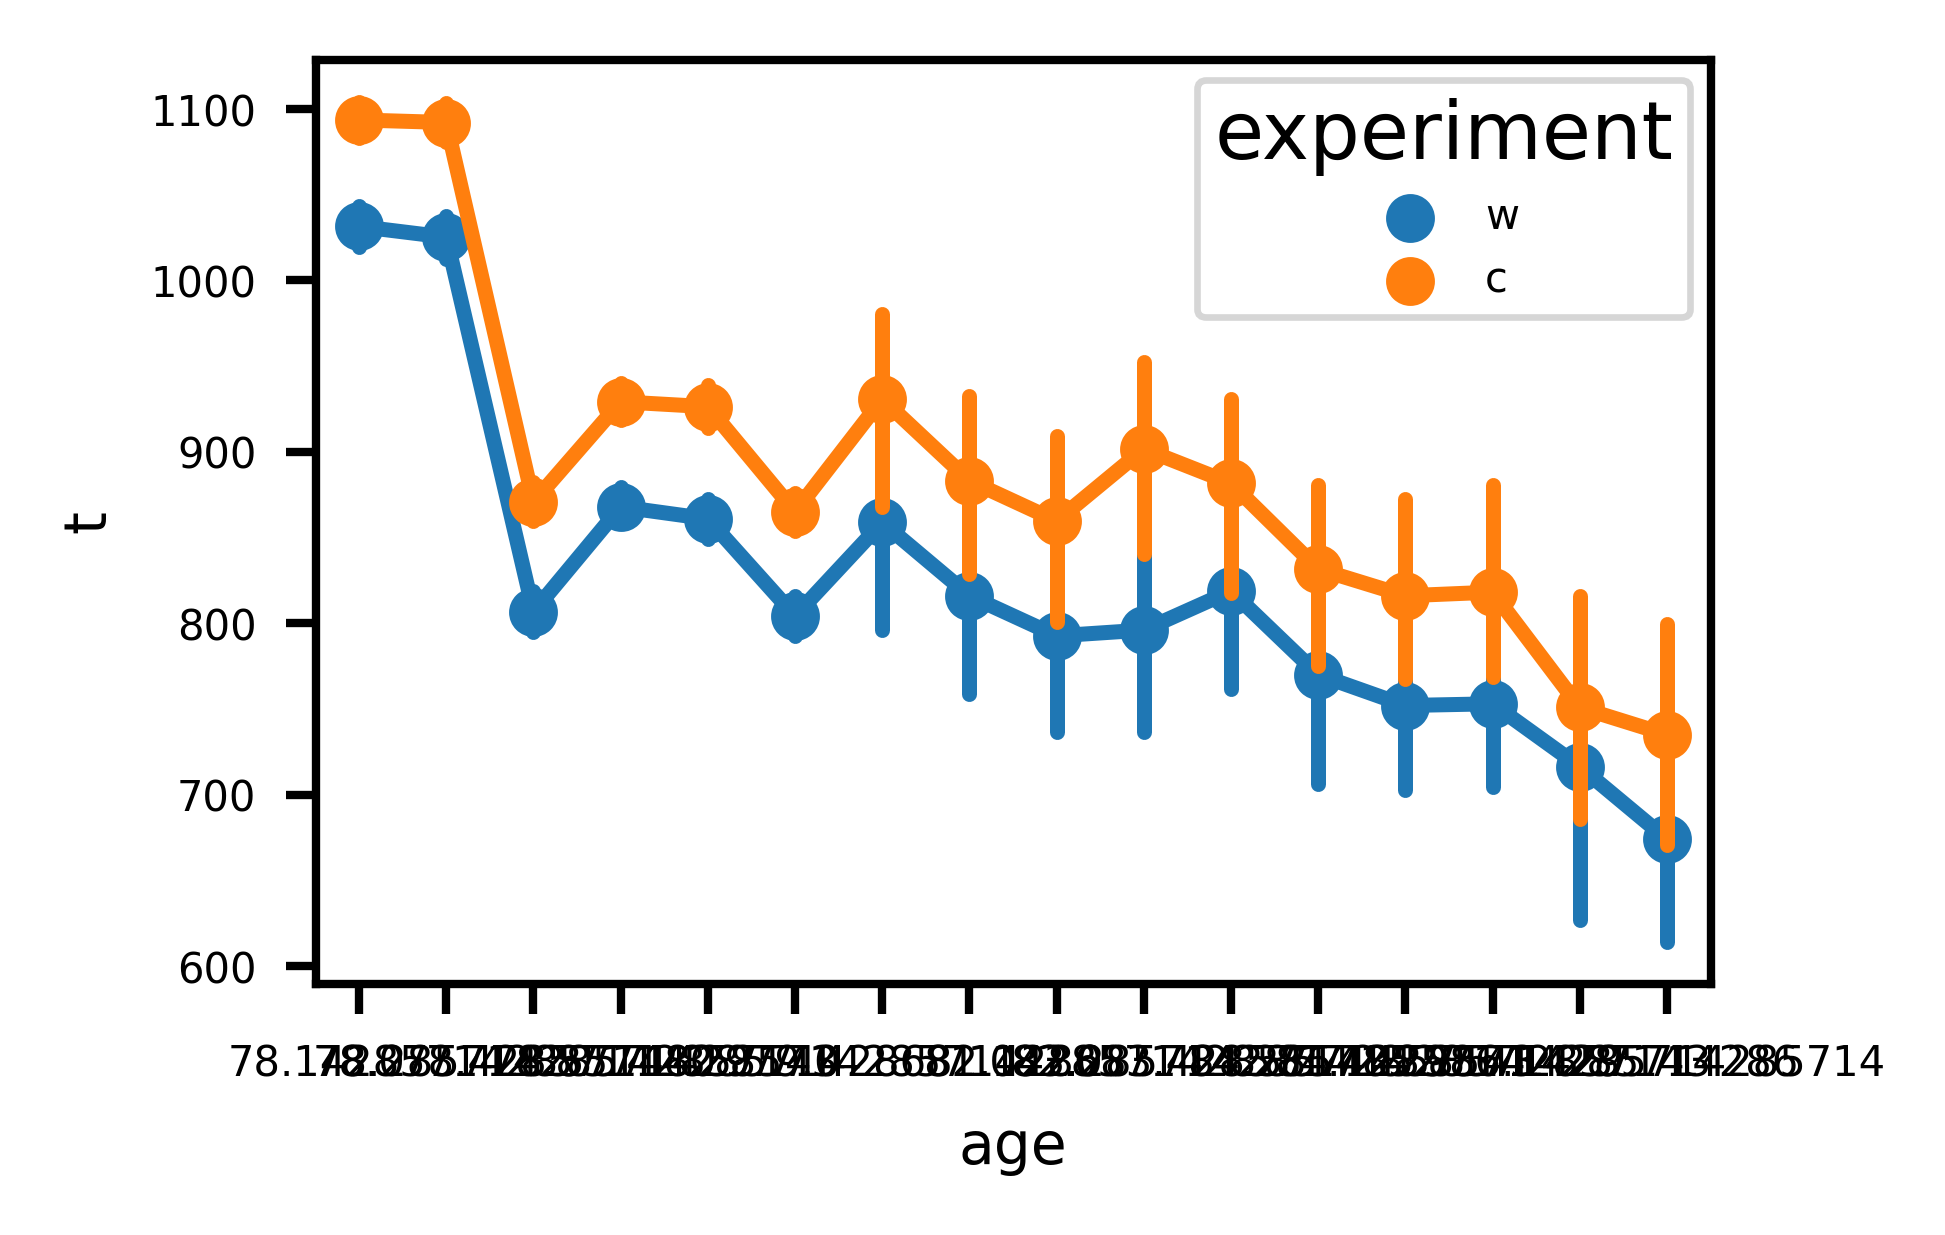

In [214]:
figure(3, 2)
ax = sns.pointplot(data=pred_df.query('age > 40'), x='age', y='t', hue='experiment')
# plt.plot([0, 90], [0, 90], ls='--', c='k')

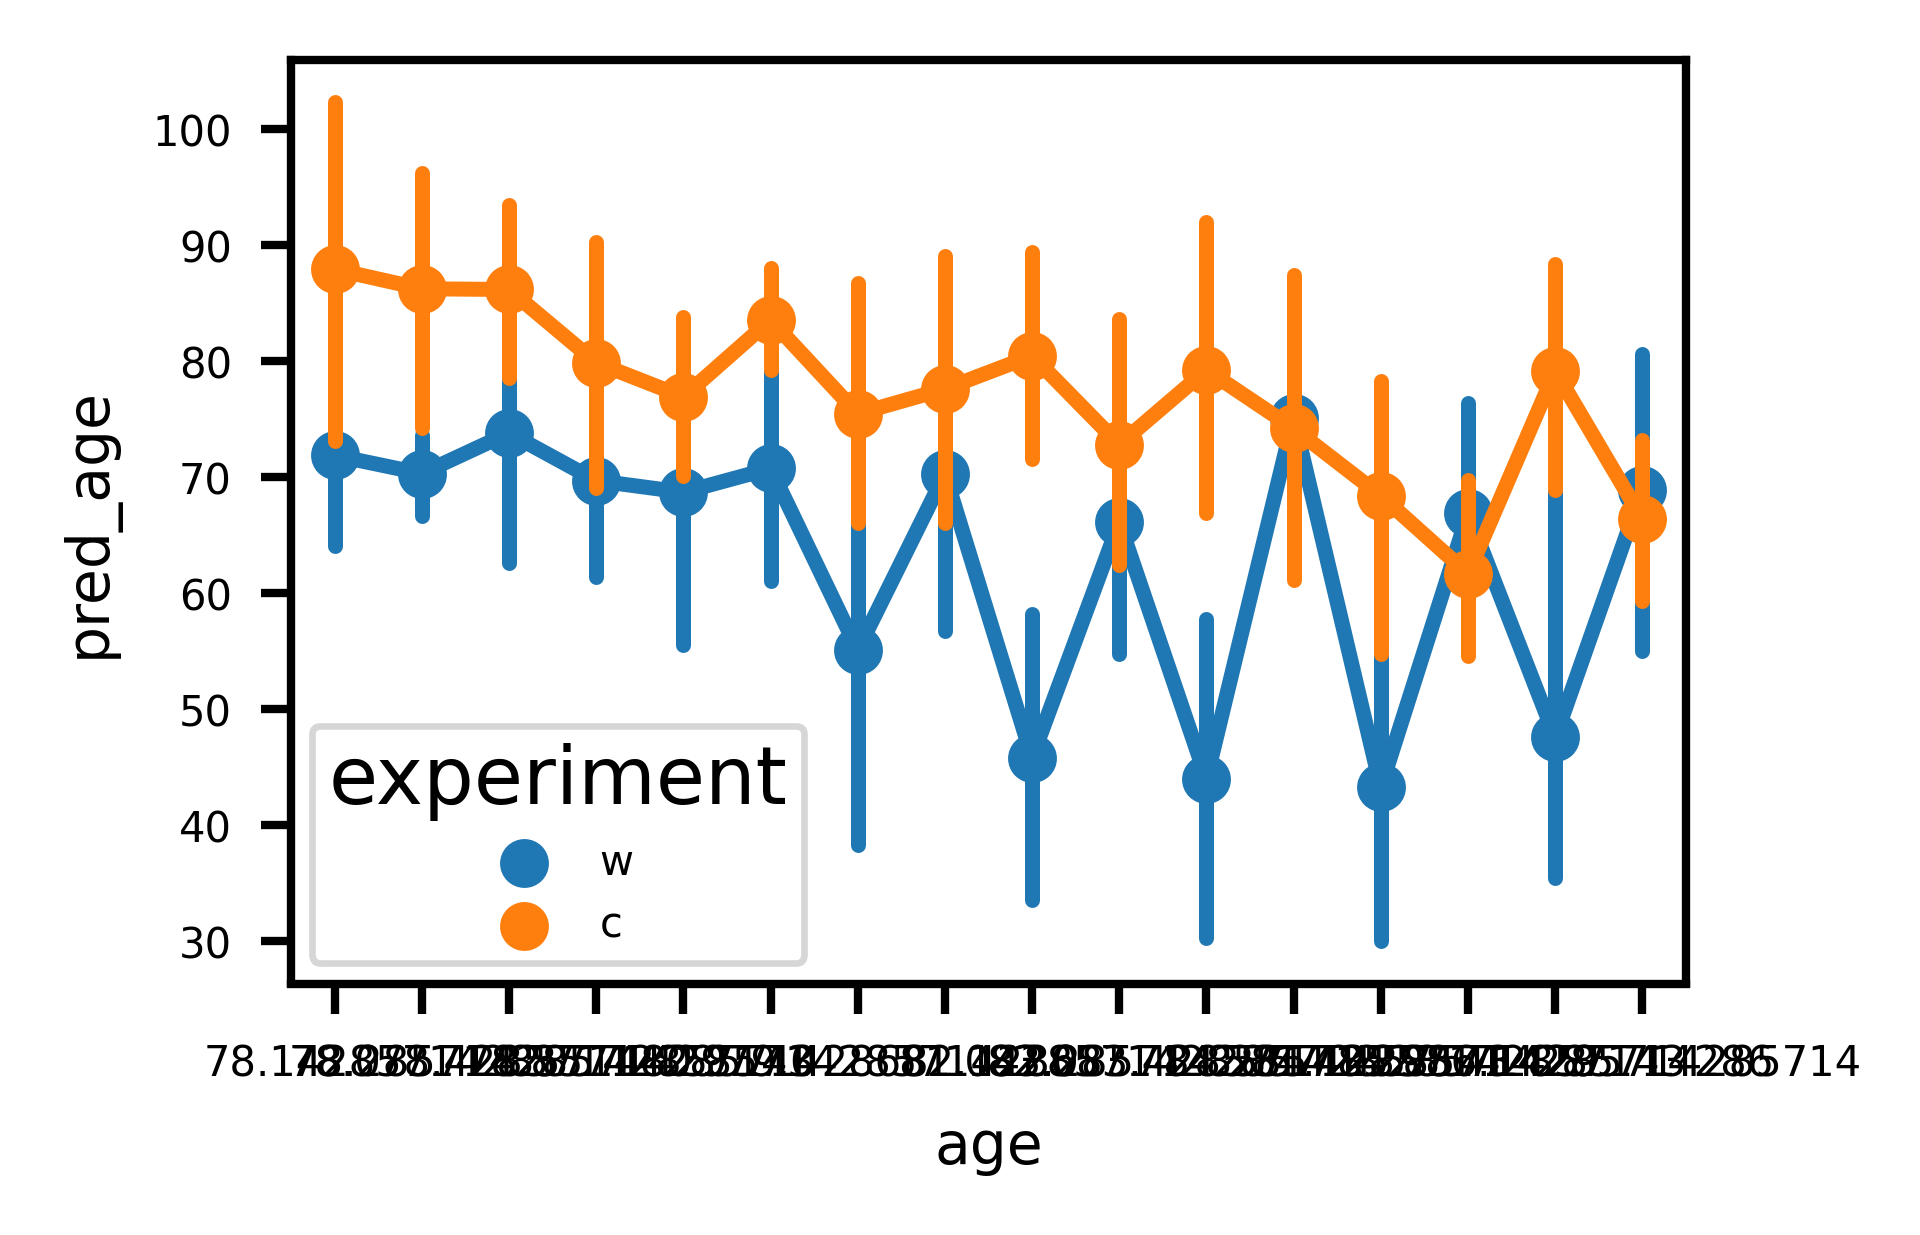

In [201]:
figure(3, 2)
ax = sns.pointplot(data=pred_df.query('age > 40'), x='age', y='pred_age', hue='experiment')
# plt.plot([0, 90], [0, 90], ls='--', c='k')

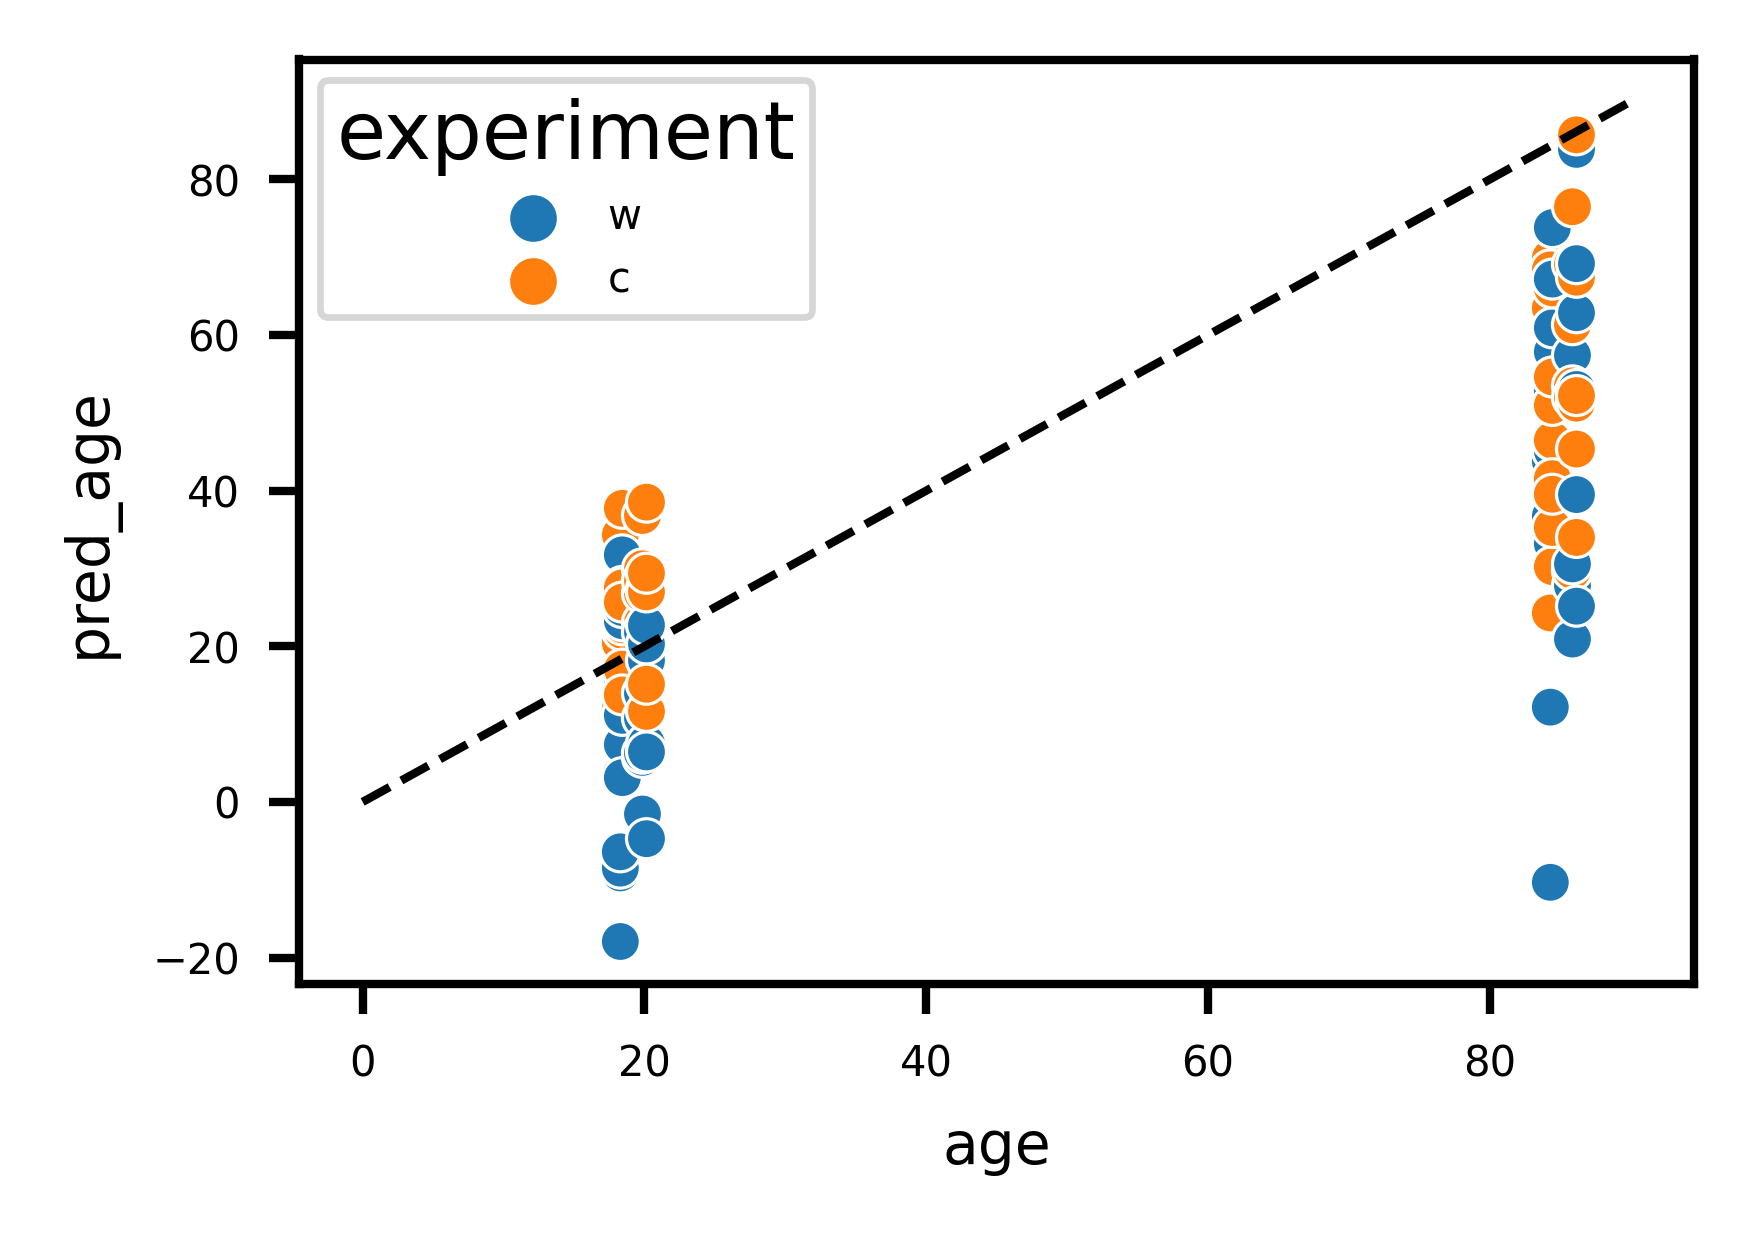

In [120]:
figure(3, 2)
ax = sns.scatterplot(data=pred_df, x='age', y='pred_age', hue='experiment')
plt.plot([0, 90], [0, 90], ls='--', c='k')

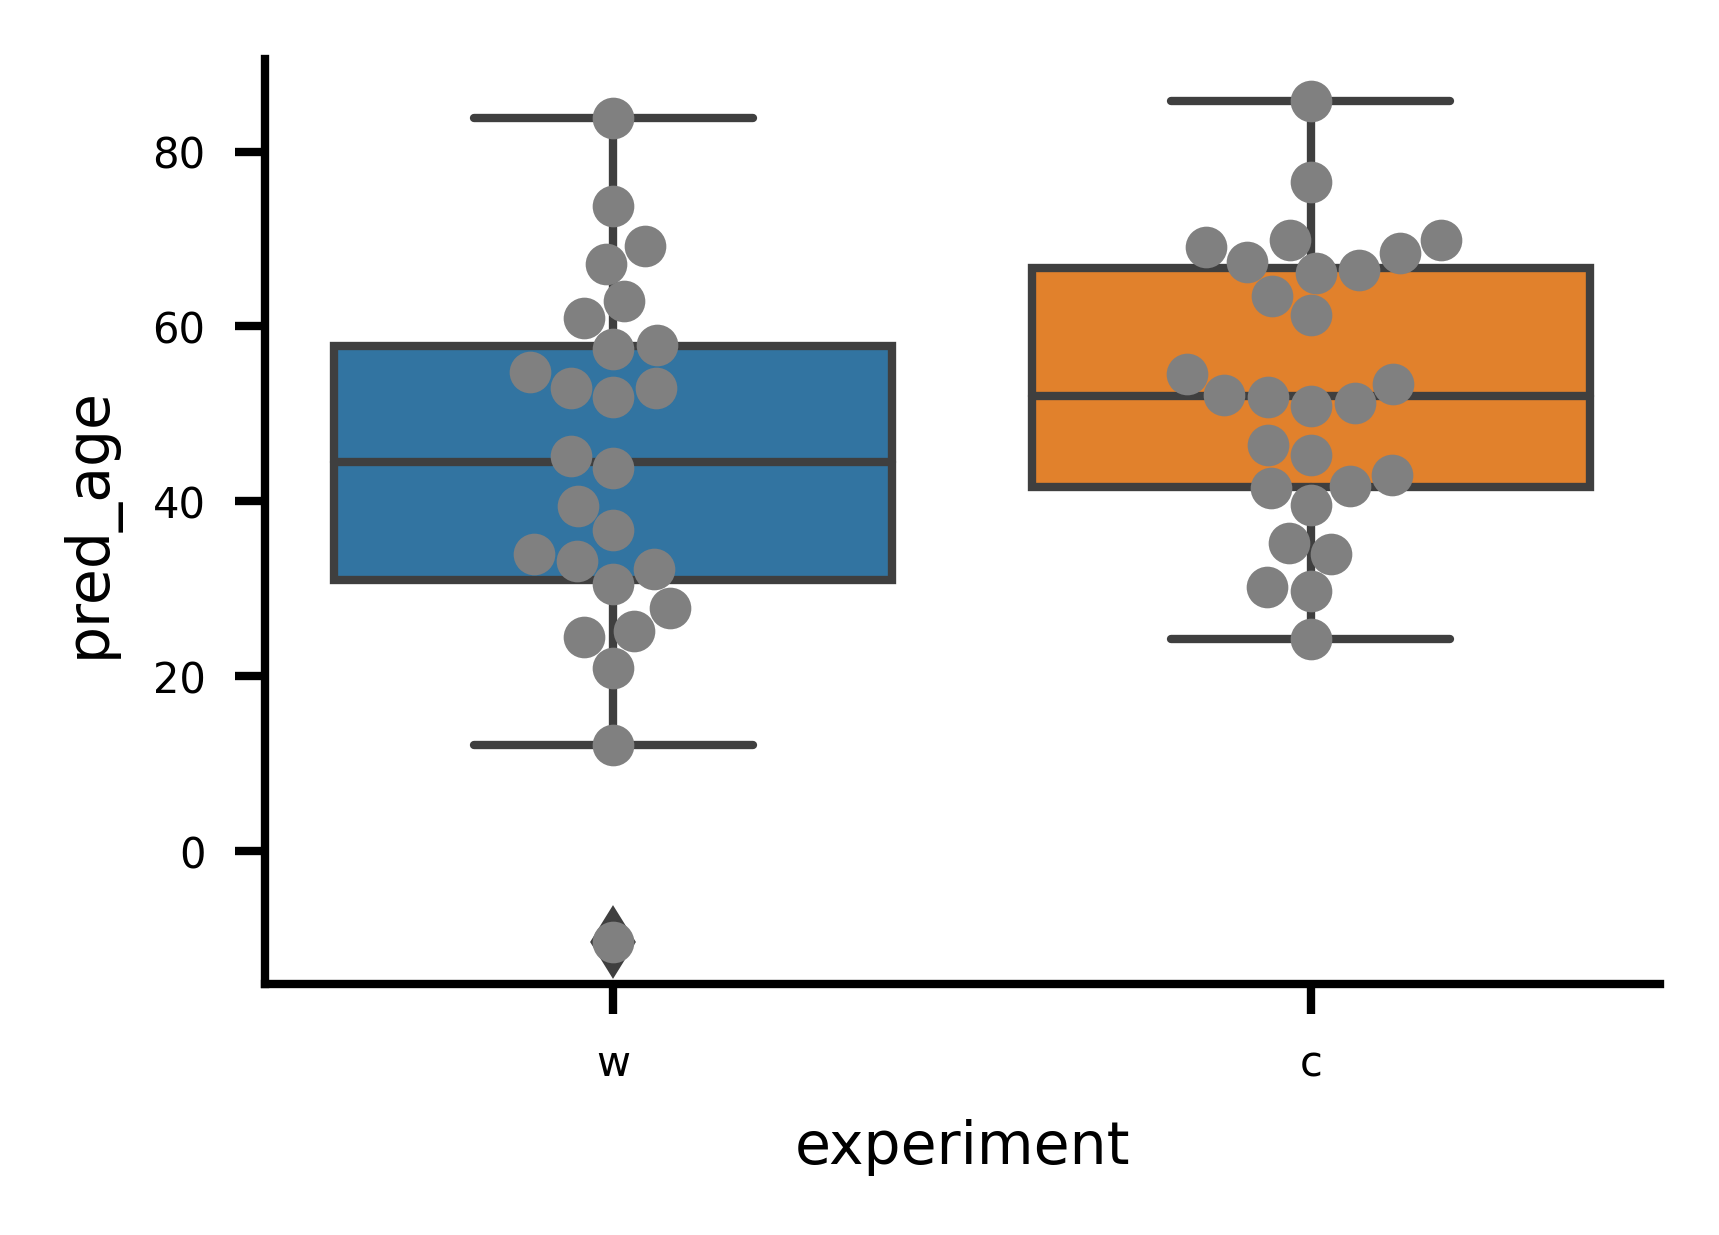

In [121]:
figure(3, 2)
ax = sns.boxplot(data=pred_df.query('age > 40'), x='experiment', y='pred_age')
ax = sns.swarmplot(data=pred_df.query('age > 40'), x='experiment', y='pred_age', color='gray')
sns.despine()

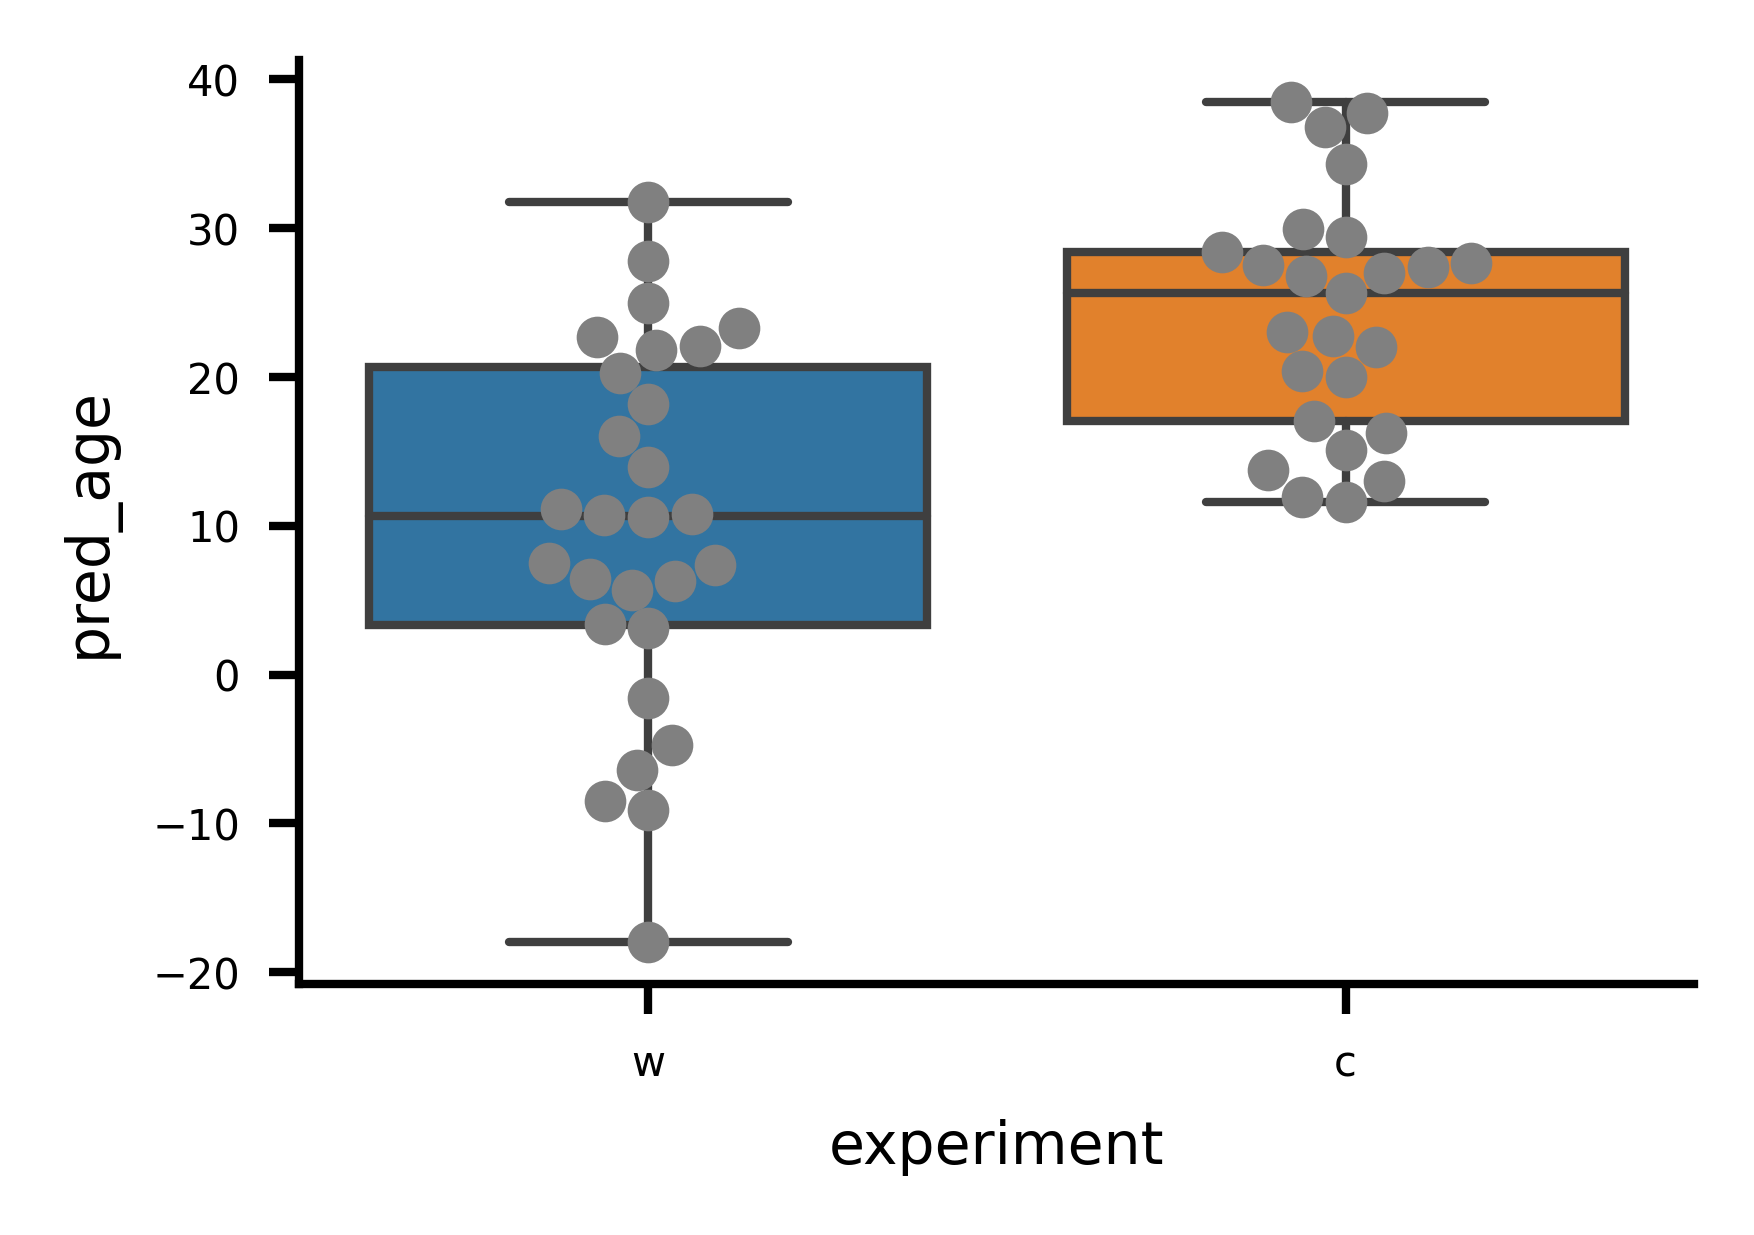

In [122]:
figure(3, 2)
ax = sns.boxplot(data=pred_df.query('age < 40'), x='experiment', y='pred_age')
ax = sns.swarmplot(data=pred_df.query('age < 40'), x='experiment', y='pred_age', color='gray')
sns.despine()

In [123]:
stats.ranksums(
    pred_df.query('experiment == "w" & age > 40')["pred_age"],
    pred_df.query('experiment == "c" & age > 40')["pred_age"],
)

RanksumsResult(statistic=-1.6273143052747518, pvalue=0.10367036121365736)

In [124]:
stats.ranksums(
    pred_df.query('experiment == "w" & age < 40')["pred_age"],
    pred_df.query('experiment == "c" & age < 40')["pred_age"],
)

RanksumsResult(statistic=-4.16927537383382, pvalue=3.055696098360047e-05)

In [125]:
stats.kruskal(
    pred_df.query('experiment == "w" & age > 40')["pred_age"],
    pred_df.query('experiment == "c" & age > 40')["pred_age"],
)

KruskalResult(statistic=2.648151848151855, pvalue=0.1036703612136571)

In [126]:
stats.kruskal(
    pred_df.query('experiment == "w" & age < 40')["pred_age"],
    pred_df.query('experiment == "c" & age < 40')["pred_age"],
)

KruskalResult(statistic=17.382857142857148, pvalue=3.055696098360037e-05)